In [2]:
import yfinance as yf
import pandas as pd

tickers = ["MSFT", "AAPL"]

# auto_adjust=True returns adjusted closes under "Close"
raw = yf.download(tickers, start="2023-01-01", end="2024-01-01",
                  progress=False, auto_adjust=True, group_by="column")

# Works whether columns are MultiIndex or not
if isinstance(raw.columns, pd.MultiIndex):
    prices = raw.xs("Close", axis=1, level=0, drop_level=True)
else:
    prices = raw[["Close"]].rename(columns={"Close": tickers[0]})  # single ticker case




## Implemented 2 engineering features here

In [3]:
import numpy as np

df = prices.copy()

#1 Spread Z-Score
df["spread"] = df["MSFT"] - df["AAPL"]
df["spread_zscore"] = (df["spread"] - df["spread"].rolling(20).mean()) / df["spread"].rolling(20).std()

#2 Volatility Ratio (5d vs 20d)
df["vol_ratio"] = df["MSFT"].pct_change().rolling(5).std() / df["MSFT"].pct_change().rolling(20).std()

#3 Spread Momentum
df["spread_momentum"] = df["spread"].diff()

df.tail()


Ticker,AAPL,MSFT,spread,spread_zscore,vol_ratio,spread_momentum
Date,,,,,,
2023-12-22,191.974686,369.767883,177.793198,0.185252,0.577073,2.097549
2023-12-26,191.429306,369.846893,178.417587,0.371764,0.553409,0.624390
2023-12-27,191.528442,369.264465,177.736023,0.411576,0.586603,-0.681564
2023-12-28,191.954849,370.458832,178.503983,0.749015,0.389932,0.767960
2023-12-29,190.913651,371.209167,180.295517,1.439333,0.216596,1.791534


### Rationale for Feature 1 (spread_zscore):
This measures how far the MSFT–AAPL spread is from its historical mean in standardized units. In statistical arbitrage, large positive or negative z-scores may indicate mispricing or divergence, which can help detect profitable or risky regimes.

### Rationale for Feature 2 (vol_ratio):
This compares short-term (5-day) volatility to longer-term (20-day) volatility. A high ratio suggests recent instability, which often signals regime shifts where the strategy may underperform.

### Rationale for Feature 3 (Spread momentum): 
Spread momentum helps capture sudden directional moves in the spread, which could precede a breakdown of mean-reversion assumptions.)

In [5]:
# Save raw prices
prices.to_csv("./data/raw/prices_msft_aapl.csv")

# Save engineered dataset
df.to_csv("./data/processed/features_stat_arb.csv")


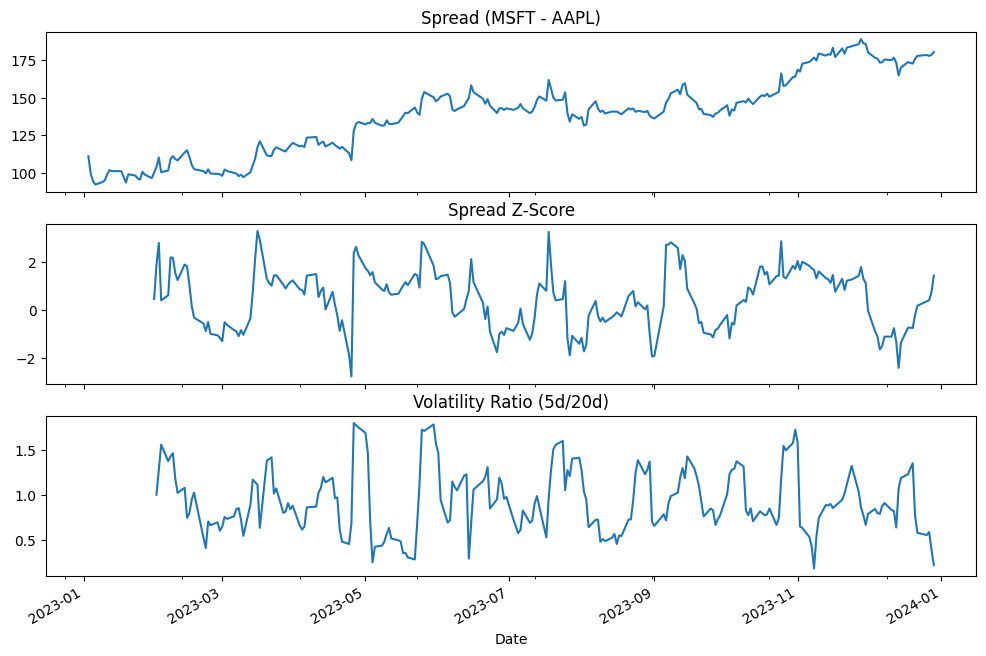

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 1, figsize=(12,8), sharex=True)
df["spread"].plot(ax=ax[0], title="Spread (MSFT - AAPL)")
df["spread_zscore"].plot(ax=ax[1], title="Spread Z-Score")
df["vol_ratio"].plot(ax=ax[2], title="Volatility Ratio (5d/20d)")
plt.show()
